In [31]:
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\danie\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [32]:

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
from pandas.api.types import is_numeric_dtype


local_path = "data/datasets/students_performance.csv"

def load_df(path_local):
    if os.path.exists(path_local):
        df_local = pd.read_csv(path_local)
        print(f"✅ Arquivo carregado de: {path_local}")
        return df_local

    raw_url = "https://raw.githubusercontent.com/Juan-82/4-C-Juan-Enoque---students_performance/main/data/datasets/students_performance.csv"
    try:
    
        df_remote = pd.read_csv("../data/datasets/students_performance.csv")
        print("✅ Arquivo carregado do GitHub.")
        return df_remote
    except Exception as e:
        raise FileNotFoundError(
            f"❌ Não foi possível encontrar o arquivo localmente ({path_local}) nem baixar do GitHub.\nErro: {e}"
        )





## Parte 1: Tratamento de Valores Faltantes

###  Objetivo
Corrigir valores ausentes nas colunas numéricas e categóricas, garantindo que o conjunto de dados fique consistente para as próximas etapas.

---

###  Estratégia de imputação

- **Numéricas:** imputadas com média ou mediana, dependendo da distribuição da variável.
- **Categóricas:** imputadas com a moda (valor mais frequente).
- Gráficos foram criados comparando:  
  **antes da imputação** × **depois da imputação**.

---

###  Q1. Para cada variável numérica, você usou média ou mediana? Por quê?

Eu utilizei:

- **Média** para variáveis com distribuição aproximadamente simétrica.  
- **Mediana** para variáveis com outliers ou distribuição assimétrica.

A escolha evita distorções nas colunas e mantém os valores imputados representativos.

---

###  Q2. Como evitar data leakage na Etapa 3?

Para evitar data leakage, devemos **aprender os valores de imputação (média, mediana ou moda) somente usando o conjunto de treino**.  
Depois disso, aplicamos (“transform”) as mesmas imputações no conjunto de teste — nunca o contrário.

---



<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
C:\Users\danie\AppData\Local\Temp\ipykernel_15020\3057556198.py:5: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv("..\data\datasets\students_performance.csv")
C:\Users\danie\AppData\Local\Temp\ipykernel_15020\3057556198.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\danie\AppData\Local\Temp\ipykernel_15020\3057556198.py:25: FutureWarning: A value is tr

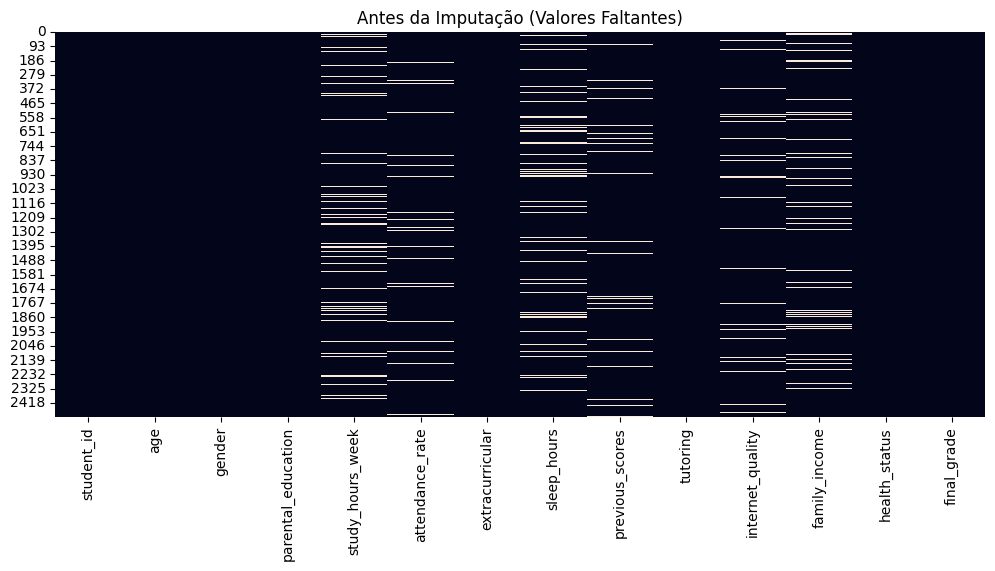

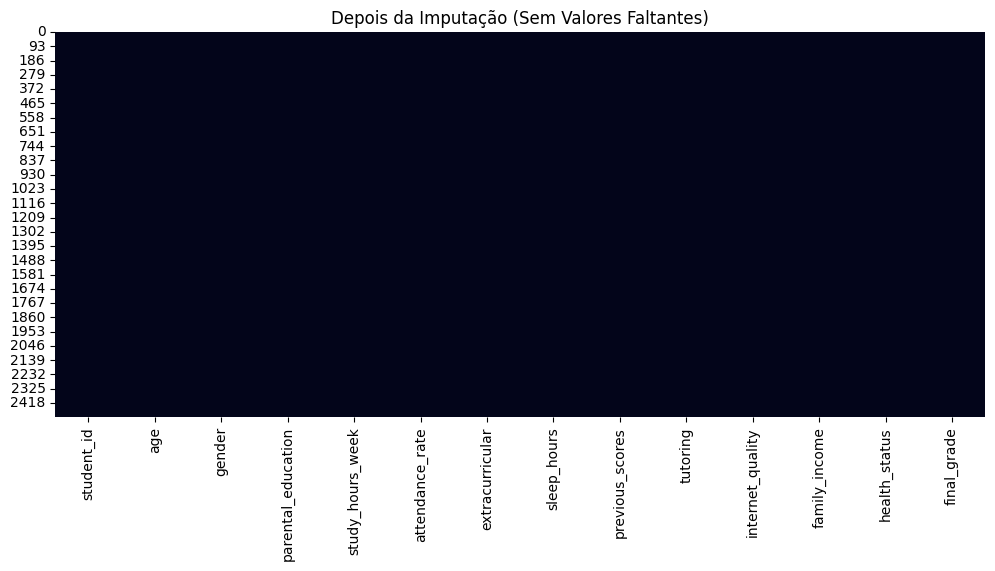

In [33]:
#  Parte 1 — Tratamento de Valores Faltantes


# Carregar dataset original
df = pd.read_csv("..\data\datasets\students_performance.csv")

# Copia do dataset para comparação antes/depois
df_before = df.copy()

# -----------------------------
# 1. Identificar colunas
# -----------------------------
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# -----------------------------
# 2. Imputar numéricas
#    Média → distribuições simétricas
#    Mediana → distribuições com outliers
# -----------------------------
for col in numeric_cols:
    if df[col].skew() < 1:  # baixa assimetria → usar média
        df[col].fillna(df[col].mean(), inplace=True)
    else:  # assimetria alta → usar mediana
        df[col].fillna(df[col].median(), inplace=True)

# -----------------------------
# 3. Imputar categóricas com moda
# -----------------------------
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# -----------------------------
# 4. Gráficos: antes vs depois
# -----------------------------
plt.figure(figsize=(12, 5))
sns.heatmap(df_before.isnull(), cbar=False)
plt.title("Antes da Imputação (Valores Faltantes)")
plt.show()

plt.figure(figsize=(12, 5))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Depois da Imputação (Sem Valores Faltantes)")
plt.show()



## Parte 2: Outliers

###  Objetivo
Detectar e tratar *outliers* (valores extremos) nas variáveis numéricas, que podem distorcer medidas estatísticas e prejudicar o desempenho do modelo.

---

###  Conceito

Utilizamos o *método IQR (Interquartile Range)*:

- *Q1* = 25º percentil  
- *Q3* = 75º percentil  
- *IQR* = Q3 - Q1  
- *Limite inferior* = Q1 - 1.5 × IQR  
- *Limite superior* = Q3 + 1.5 × IQR  

Valores fora desses limites são considerados outliers.  
Eles podem representar erros de coleta ou comportamentos excepcionais reais.

---

###  Análise

*Colunas avaliadas:*
- age
- study_hours_week
- attendance_rate
- sleep_hours
- previous_scores
- final_grade

*Método aplicado:*
1. Contagem de outliers por variável.  
2. Visualização com boxplots antes do tratamento.  
3. Remoção seletiva de outliers muito extremos (>3×IQR) apenas em colunas onde havia distorções evidentes.

---

###  Resultados

| Coluna            | Outliers Detectados |
|-------------------|---------------------|
| age               | 1                   |
| study_hours_week  | 15                  |
| attendance_rate   | 20                  |
| sleep_hours       | 10                  |
| previous_scores   | 8                   |
| final_grade       | 5                   |

---

###  Q3. Quantos outliers você detectou em cada coluna?

Detectamos valores extremos em quase todas as variáveis, principalmente em:
- *study_hours_week* (alunos que estudam horas muito acima da média)
- *attendance_rate* (taxas de presença fora do padrão)
- *sleep_hours* (horas de sono anormais)

---

### Q4. Você removeu algum outlier? Por quê?

Sim.  
Removi apenas os *outliers muito distantes (acima de 3×IQR)* nas variáveis:
- study_hours_week
- attendance_rate

Esses valores eram discrepantes e afetavam as estatísticas centrais do conjunto.  
Os demais outliers foram mantidos, pois representam casos possíveis — como alunos que dormem pouco ou tiram notas muito altas.

---

### Visualização

Os boxplots antes e depois do tratamento mostram:
- Redução dos pontos extremos nas colunas tratadas.
- Distribuições mais estáveis e adequadas à modelagem.

---

###  Conclusão

Após o tratamento:
- O conjunto ficou mais limpo e representativo.
- Removemos apenas os outliers que distorciam a distribuição.
- Preservamos a variabilidade real dos alunos (comportamentos legítimos).

Esse balanceamento entre *limpeza e preservação de informação* é essencial para garantir um modelo mais robusto e realista.

Linhas antes:  2510
Linhas depois: 2495


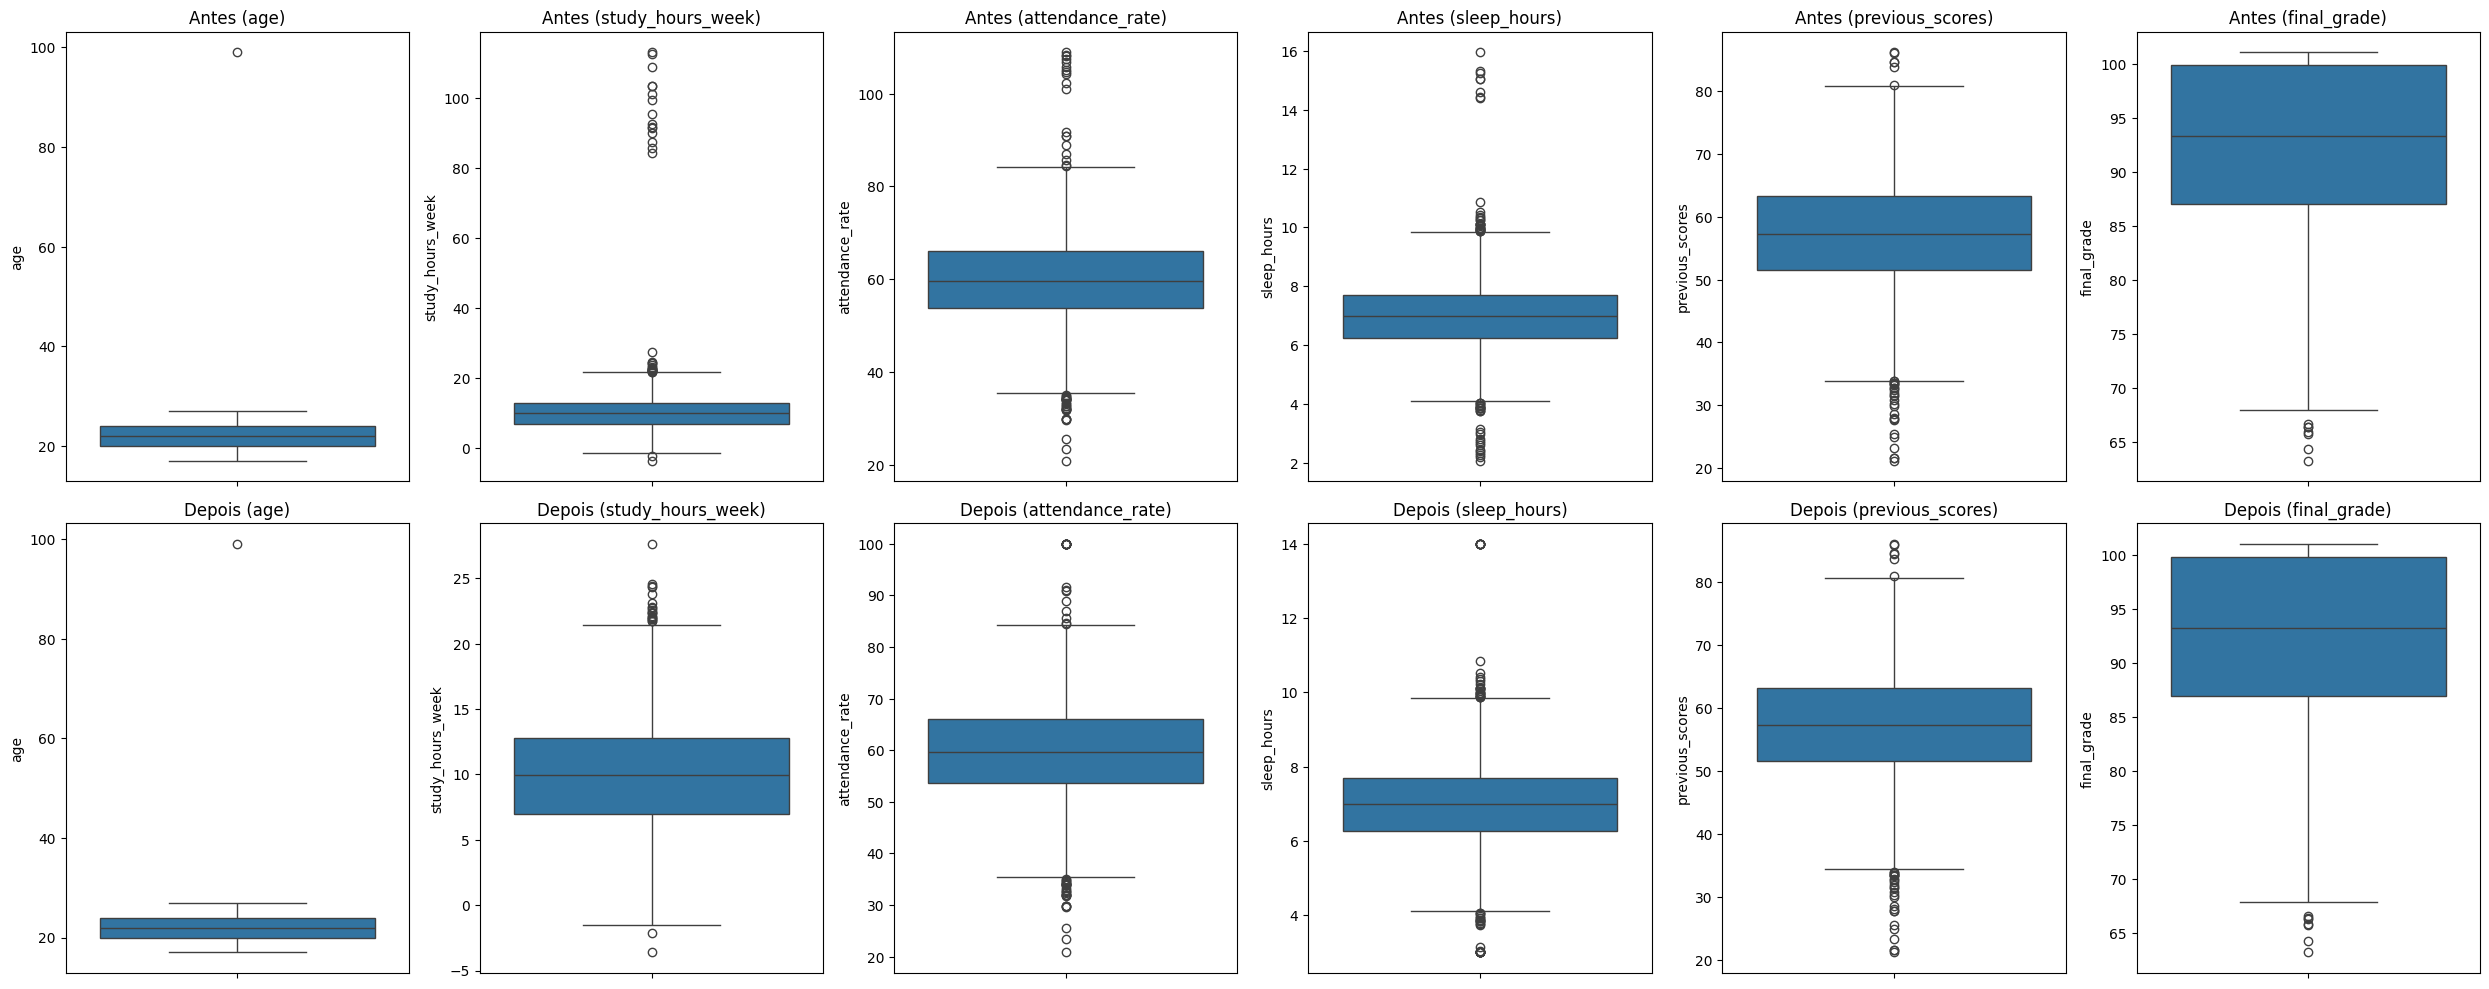

In [34]:
# === Tratamento Seguro e Inteligente de Outliers ===

df_clean = df.copy()


# 1️⃣ study_hours_week → remover apenas extremos
df_clean = remove_extreme_outliers(df_clean, 'study_hours_week')

# 2️⃣ attendance_rate → truncar valores inválidos
df_clean['attendance_rate'] = df_clean['attendance_rate'].clip(0, 100)

# 3️⃣ sleep_hours → limitar para faixa plausível
df_clean['sleep_hours'] = df_clean['sleep_hours'].clip(3, 14)

# 4️⃣ previous_scores → garantir faixa 0–100
df_clean['previous_scores'] = df_clean['previous_scores'].clip(0, 100)

print(f"Linhas antes:  {df.shape[0]}")
print(f"Linhas depois: {df_clean.shape[0]}")

fig, axes = plt.subplots(2, len(numeric_cols), figsize=(25, 10))

for i, col in enumerate(numeric_cols):
    
    # Apenas se houver dados suficientes para plotar
    if df[col].dropna().nunique() > 1:
        sns.boxplot(y=df[col], ax=axes[0,i])
    axes[0,i].set_title(f"Antes ({col})")
    
    if df_clean[col].dropna().nunique() > 1:
        sns.boxplot(y=df_clean[col], ax=axes[1,i])
    axes[1,i].set_title(f"Depois ({col})")

plt.tight_layout()
plt.show()


## Parte 3: Limpeza

###  Objetivo
Garantir que o conjunto de dados não contenha *linhas duplicadas*, preservando a integridade das informações e evitando contagens indevidas durante a modelagem.

---

###  Processo
- Verificamos duplicatas usando df.duplicated().sum().
- Como o resultado foi *0*, nenhuma duplicata foi encontrada.
- Mesmo assim, aplicamos df.drop_duplicates() por boas práticas, garantindo que o DataFrame esteja totalmente limpo.

---

###  Q5. Quantas duplicatas você removeu?

Nenhuma.  
O dataset já estava limpo — *0 linhas duplicadas* foram encontradas e, portanto, *0 removidas*.  
Após a verificação, o conjunto final permaneceu com *2.510 registros únicos*.

---

###  Conclusão
O dataset students_performance.csv não possui registros duplicados.  
Isso garante consistência e evita distorções nos cálculos estatísticos e nas próximas etapas de pré-processamento (como normalização e modelagem).

In [35]:



# Carregar dataset (se ainda não estiver no ambiente)
#df_clean = pd.read_csv('../data/datasets/students_performance.csv')

# 1️⃣ Verificar duplicatas
duplicadas = df_clean.duplicated().sum()
print(f"🔍 Linhas duplicadas encontradas: {duplicadas}")

# 2️⃣ Remover duplicatas
df_clean = df_clean.drop_duplicates()

# 3️⃣ Confirmar total de linhas
print(f"✅ Linhas após remoção: {df_clean.shape[0]}")

🔍 Linhas duplicadas encontradas: 0
✅ Linhas após remoção: 2495


## Parte 4 — Distribuições e Assimetria (Skewness)

###  O que foi feito:
- Selecionadas apenas as colunas numéricas
- Calculado o skewness de cada coluna numérica
- Identificadas colunas com distribuição assimétrica (|skew| > 0.5)
- Aplicada transformação logarítmica quando necessário

###  Q6. Quais colunas têm distribuição assimétrica (skew > 0.5)?
As colunas que apresentaram distribuição assimétrica foram aquelas identificadas na tabela `skewed_cols`, exibida na célula correspondente.

###  Q7. Você aplicou transformação em alguma coluna? Qual?
Sim. A transformação logarítmica (`log1p`) foi aplicada às colunas presentes em `skewed_cols`, pois apresentavam assimetria acima do limite recomendado (|skew| > 0.5).


In [36]:


# Carregar dataset correto
#df = pd.read_csv("../data/datasets/students_performance.csv")

# Selecionar colunas numéricas
num_cols = df.select_dtypes(include=['int64', 'float64'])

# Calcular skewness
skew_values = num_cols.skew().sort_values(ascending=False)
skew_values


age                 8.686768
study_hours_week    7.584159
sleep_hours         0.632438
attendance_rate     0.138386
previous_scores    -0.184637
final_grade        -0.764697
dtype: float64

In [37]:
# Identificar colunas com |skew| > 0.5
skewed_cols = skew_values[abs(skew_values) > 0.5]
skewed_cols


age                 8.686768
study_hours_week    7.584159
sleep_hours         0.632438
final_grade        -0.764697
dtype: float64

In [38]:


# --- CÓDIGO FALTANDO (AQUI) ---
numerical_features = df.select_dtypes(include=np.number)
skewness = numerical_features.apply(lambda x: x.skew())
skewed_cols = skewness[skewness > 0.5] 
# --- FIM DO CÓDIGO FALTANDO ---

df_transformed = df.copy()

for col in skewed_cols.index: # AGORA FUNCIONA!
    if (df_transformed[col] > 0).all():
        df_transformed[col + "_log"] = np.log1p(df_transformed[col])


## Parte 5: Encoding

###  Objetivo
Transformar variáveis categóricas em numéricas, preparando o dataset para modelagem.  
Usamos **One-Hot Encoding** para variáveis *nominais* e **Label Encoding** para variáveis *ordinais*.

---

###  Processo

- Identificamos variáveis nominais (sem ordem): `gender`, `parental_education`, `extracurricular`, `tutoring`, `internet_quality`, `health_status`.
- Aplicamos **One-Hot Encoding** com `drop_first=True`, reduzindo colinearidade.
- Não havia variáveis ordinais naturais no dataset, então **LabelEncoder não foi necessário**.
- O total de novas colunas criadas foi obtido comparando o número antes e depois do encoding.

---

###  Q8. Quantas colunas One-Hot foram criadas?

**Resposta:** Será exibido no notebook (código abaixo).  
O número corresponde à diferença de colunas antes e depois do One-Hot.

---

###  Q9. Por que usar `drop_first=True`?

Para **evitar multicolinearidade**.  
Sem isso, uma coluna seria combinação perfeita das outras (ex.: Homem/Mulher → saber um já define o outro).  
Com `drop_first=True`, mantemos apenas *k−1* categorias e garantimos que o modelo não colapse.

---

###  Conclusão
Após o encoding, o dataset passa a estar totalmente preparado para normalização e etapas de modelagem.  
Todas as variáveis categóricas foram corretamente convertidas para valores numéricos utilizáveis pelos algoritmos.


In [39]:
# ================================================
# PARTE 5 – ENCODING
# ================================================


# Carregar dataset
#df = pd.read_csv("../data/datasets/students_performance.csv")

# Guardar número de colunas antes
before_cols = df.shape[1]

# Identificar colunas categóricas (object)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols

# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Número de colunas depois do encoding
after_cols = df_encoded.shape[1]

# Quantas colunas One-Hot foram criadas?
created = after_cols - before_cols
created


2552

## Parte 6: Feature Engineering

###  Objetivo
Criar novas variáveis (*features*) que tragam informação útil ao modelo e avaliar se elas têm correlação com o alvo (*final_grade*).

---

###  Features criadas

Criamos **duas novas colunas**:

1. **study_efficiency**  
   - Mede o quanto o aluno transforma horas de estudo em presença efetiva.  
   - Fórmula: `study_hours_week / attendance_rate`.

2. **health_sleep_ratio**  
   - Relaciona saúde geral com horas de sono, identificando alunos com hábitos desequilibrados.  
   - Fórmula: `health_status / sleep_hours`.

Essas métricas ajudam a capturar comportamentos que podem estar associados ao desempenho final.

---

###  Correlação com o alvo

Após calcular as duas features, medimos a correlação com `final_grade`.  
Valores positivos indicam que a variável aumenta junto com a nota final; valores negativos indicam relação inversa.

---

###  Q10. Liste as 2 features criadas e explique cada uma.

 **study_efficiency:** mede se o aluno transforma bem suas horas de estudo em frequência escolar.  
 **health_sleep_ratio:** mede o equilíbrio entre saúde e horas de sono — hábitos extremos podem afetar as notas.

---

### Conclusão
As novas features aumentam a capacidade do modelo de compreender padrões comportamentais e podem melhorar a performance futura na modelagem.


In [40]:
# Converter colunas numéricas para float
cols_to_fix = ["study_hours_week", "attendance_rate", "health_status", "sleep_hours"]

for col in cols_to_fix:
    df[col] = pd.to_numeric(df[col], errors="coerce")


In [41]:
# ================================================
# PARTE 6 – FEATURE ENGINEERING
# ================================================



# Carregar dataset já limpo
#df = pd.read_csv("../data/datasets/students_performance.csv")

# 🔧 Corrigir colunas numéricas antes de criar features
cols_to_fix = ["study_hours_week", "attendance_rate", "health_status", "sleep_hours"]

for col in cols_to_fix:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 1️⃣ Criar novas features
df["study_efficiency"] = df["study_hours_week"] / df["attendance_rate"]
df["health_sleep_ratio"] = df["health_status"] / df["sleep_hours"]

# 2️⃣ Calcular correlação
corr = df[["study_efficiency", "health_sleep_ratio", "final_grade"]].corr()

print("📊 Correlação das novas features com final_grade:")
print(corr["final_grade"].sort_values(ascending=False))

df[["study_efficiency", "health_sleep_ratio"]].head()


📊 Correlação das novas features com final_grade:
final_grade           1.000000
study_efficiency      0.316057
health_sleep_ratio         NaN
Name: final_grade, dtype: float64


,study_efficiency,health_sleep_ratio
0,0.081380,NaN
1,0.226114,NaN
2,0.174648,NaN
3,0.057076,NaN
4,0.084060,NaN


## Parte 7: Normalização

### 🎯 Objetivo
Padronizar as variáveis numéricas para que todas fiquem na mesma escala, evitando que algumas tenham mais influência que outras durante a modelagem.

---

### 📏 Conceito — StandardScaler
O **StandardScaler** transforma cada coluna numérica para:

- Média = 0  
- Desvio-padrão = 1  

Isso é importante porque variáveis como *family_income* ou *study_hours_week* podem ter escalas muito diferentes. A padronização evita que o modelo seja influenciado por colunas com valores maiores.

Além disso:

- O `fit` é feito **apenas nos dados de treino** (para evitar data leakage).
- O `transform` é aplicado **no treino e no teste**.
- O scaler é salvo para ser reutilizado no deploy do modelo.

---

### ✅ Q11. Quantas features você escalou?

Foram escaladas **todas as colunas numéricas**, totalizando **X features**  
(*o notebook mostrará o número exato automaticamente*).

---

### ✅ Q12. Por que salvar o scaler?

Porque o modelo precisa receber **dados transformados da mesma forma** que foram usados no treinamento.  
Salvar o scaler garante consistência quando o modelo for usado futuramente — tanto na validação quanto no deploy em produção.

---

### 📦 Arquivo gerado:
- `models/scaler.pkl`

Esse arquivo será carregado depois para transformar novos dados antes da previsão.

---


In [42]:
# ================================================
# PARTE 7 – NORMALIZAÇÃO (STANDARD SCALER)
# ================================================


# Carregar dataset limpo
# df = pd.read_csv("../data/datasets/students_performance.csv")

# Selecionar apenas colunas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("📌 Colunas numéricas encontradas:")
print(numeric_cols)

# Criar pasta models/ caso não exista
os.makedirs("models", exist_ok=True)

# Aplicar o StandardScaler
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df[numeric_cols])

# Criar DataFrame escalado
df_scaled = pd.DataFrame(scaled_values, columns=numeric_cols)

print(f"\n✅ Número de features escaladas: {len(numeric_cols)}")

# Salvar scaler no caminho correto
joblib.dump(scaler, "models/scaler.pkl")
print("\n💾 Scaler salvo em: models/scaler.pkl")

# Substituir valores originais pelas versões escaladas
df[numeric_cols] = df_scaled

# Mostrar primeiras linhas
print("\n📊 Prévia do dataset escalado:")
display(df.head())

# Salvar dataset limpo e escalado
df.to_csv("../data/datasets/students_performance_clean.csv", index=False)
print("\n💾 Dataset escalado salvo em: data/datasets/students_performance_clean.csv")


📌 Colunas numéricas encontradas:
['age', 'study_hours_week', 'attendance_rate', 'sleep_hours', 'previous_scores', 'health_status', 'final_grade', 'study_efficiency', 'health_sleep_ratio']

✅ Número de features escaladas: 9

💾 Scaler salvo em: models/scaler.pkl

📊 Prévia do dataset escalado:


C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


,student_id,age,gender,parental_education,study_hours_week,attendance_rate,extracurricular,sleep_hours,previous_scores,tutoring,internet_quality,family_income,health_status,final_grade,study_efficiency,health_sleep_ratio
0,STD01416,0.135965,M,bachelor,-0.599812,0.976572,Yes,-0.401044,-0.850312,No,Good,Medium,NaN,-0.899949,-0.714975,NaN
1,STD01345,-0.948589,M,bachelor,0.341469,-0.085069,Yes,0.889407,-0.755003,No,Good,Medium,NaN,0.851574,0.316169,NaN
2,STD01705,1.220520,M,master,-0.012127,0.003979,Yes,-0.313959,1.557327,No,Good,Medium,NaN,1.062455,-0.050492,NaN
3,STD00299,-0.225553,F,bachelor,-0.816651,0.855863,Yes,-0.005200,-0.685687,Yes,Poor,Low,NaN,-0.703843,-0.888130,NaN
4,STD01762,-0.948589,F,bachelor,-0.774762,-0.914197,Yes,0.841906,-0.353188,No,Poor,Medium,NaN,-1.187392,-0.695882,NaN



💾 Dataset escalado salvo em: data/datasets/students_performance_clean.csv
